In [136]:
# Import pandas as pd
import pandas as pd
from yahoofinancials import YahooFinancials as YF
from pandas_datareader import data
import time
from tqdm import tqdm
from utils import *
import matplotlib.pyplot as plt
import json
from scipy.stats import kurtosis, shapiro, skew
%matplotlib inline

In [125]:
def convert_time(epoch):
    return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(epoch))

def getStockData(tickers, days_back):
    stocks = {}
    epoch_time = int(time.time())
    day_epoch = 60*60*24
    for tick in tqdm(tickers):
        try:
            stock_data = data.DataReader(tick, 
                        start=convert_time(epoch_time - (days_back* day_epoch)), 
                        end=convert_time(epoch_time), 
                        data_source='yahoo')
            stocks[tick] = stock_data 
        except:
            print("Skipping stock for {}, bad data :<".format(tick))
    return stocks

def getSP500Tickers():
    table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    df = table[0]
    df.to_csv('S&P500-Info.csv')
    df.to_csv("S&P500-Symbols.csv", columns=['Symbol'])
    tickers = df['Symbol']
    return tickers


def getPortReturns(stocks):
    df = pd.DataFrame()
    #df.index = stocks[list(stocks.keys())[0]].index
    for stock in list(stocks):
        df[stock] = stocks[stock]['simple_returns']
    return df.dropna()


def addMACD(stocks):
    for stock in list(stocks):
        exp1 = stocks[stock]['Adj Close'].ewm(span=12, adjust=False).mean()
        exp2 = stocks[stock]['Adj Close'].ewm(span=26, adjust=False).mean()
        stocks[stock]['macd'] = exp1-exp2
        stocks[stock]['macd_signal'] = stocks[stock]['macd'].ewm(
            span=9, adjust=False).mean()
    return(stocks)


def computeRSI(data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    # this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff

    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[diff > 0]

    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[diff < 0]
    up_chg_avg = up_chg.ewm(com=time_window-1, min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(
        com=time_window-1, min_periods=time_window).mean()

    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi


def addRSI(stocks, time_window):
    for stock in list(stocks):
        stocks[stock]["RSI"] = computeRSI(
            stocks[stock]["Adj Close"], time_window)
    return(stocks)


def addBB(stocks, time_window):
    for stock in list(stocks):
        stocks[stock]['MA20'] = stocks[stock]['Adj Close'].rolling(
            window=time_window).mean()
        stocks[stock]['20dSTD'] = stocks[stock]['Adj Close'].rolling(
            window=time_window).std()
        stocks[stock]['UpperBB'] = stocks[stock]['MA20'] + \
            (stocks[stock]['20dSTD'] * 2)
        stocks[stock]['LowerBB'] = stocks[stock]['MA20'] - \
            (stocks[stock]['20dSTD'] * 2)
        stocks[stock]['LowerBB_dist'] = stocks[stock]['LowerBB'] - \
            stocks[stock]['MA20']
        stocks[stock]['UpperBB_dist'] = stocks[stock]['MA20'] - \
            stocks[stock]['UpperBB']
    return(stocks)


def addReturns(stocks):
    for stock in list(stocks):
        stocks[stock]['simple_returns'] = stocks[stock]['Adj Close'].pct_change()
        stocks[stock]['log_returns'] = np.log(
            stocks[stock]['simple_returns']+1)
        stocks[stock]['cum_daily_return'] = (
            (1 + stocks[stock]['simple_returns']).cumprod() - 1)
    return(stocks)


def addVol(stocks, periods):
    for stock in list(stocks):
        stocks[stock]['volatility'] = (stocks[stock]['simple_returns'].rolling(
            periods).std() * np.sqrt(periods))
    return stocks


def lagFeatures(stocks, features, periods, returns):
    # sets the columns we want in our final df
    cols_wanted = features + returns
    stocks_lagged = stocks.copy()
    print(f'The columns wanted are {cols_wanted}')
    for stock in list(stocks):
        stocks_lagged[stock][features] = stocks_lagged[stock][features].shift(
            periods)
        stocks_lagged[stock] = pd.DataFrame(
            stocks_lagged[stock], columns=cols_wanted)
    return(stocks_lagged)


def getRandomWeights(numstocks):
    weights = np.random.rand(numstocks)
    return (weights/np.sum(weights))


def getPortWeightedReturns(port_ret, weights):
    assert(len(port_ret.columns) == len(weights))
    return port_ret.iloc[:, 0:len(weights)].mul(weights, axis=1).sum(axis=1)
# getRandomWeights(50)


def getPortWeightedVol(port_ret, weights):
    cov_mat = port_ret.cov()
    #cov_mat_annual = cov_mat * 252
    # cov_mat_annual
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))
    return port_vol


def getPortWeightedAnnualReturn(port_ret, weights):
    returns = getPortWeightedReturns(port_ret, weights)

    mean_return_daily = np.mean(returns)
    # Calculate the implied annualized average return
    mean_return_annualized = ((1+mean_return_daily)**252)-1
    return(mean_return_annualized)

def dict_2_panel(stocks):  
    df = pd.DataFrame()
    for stock in list(stocks):
        stocks[stock]['ticker'] = stock
        df = df.append(stocks[stock])
    return df.dropna()

def graphPrice(stocks, ticker):
    plt.figure(figsize=(10,10))
    plt.plot(stocks[ticker].index, stocks[ticker]['Adj Close'])
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.title(ticker + " price")
    plt.savefig('./graphs/{}_price.png'.format(ticker))
    
def getSP500Tickers():
    table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    df = table[0]
    df.to_csv('S&P500-Info.csv')
    df.to_csv("S&P500-Symbols.csv", columns=['Symbol'])
    tickers = df['Symbol']
    return list(tickers)

def convertBytesToString(bytes):
    data = bytes.decode('utf-8').splitlines()
    df = pd.DataFrame(data)
    return(df)


In [116]:
tickers = getSP500Tickers()[:20]
stocks = getStockData(tickers,365)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.97it/s]


In [117]:
stocks

{'MMM':                   High         Low        Open       Close     Volume  \
 Date                                                                    
 2020-02-03  160.309998  156.380005  160.029999  156.589996  3927100.0   
 2020-02-04  159.960007  157.000000  159.770004  157.240005  4363900.0   
 2020-02-05  162.330002  158.699997  159.119995  162.330002  3118200.0   
 2020-02-06  165.000000  162.470001  164.490005  162.889999  3413800.0   
 2020-02-07  161.919998  159.630005  161.410004  160.080002  2736200.0   
 ...                ...         ...         ...         ...        ...   
 2021-01-25  172.490005  168.229996  168.880005  170.389999  3353100.0   
 2021-01-26  176.839996  172.080002  173.779999  175.949997  5148900.0   
 2021-01-27  187.270004  177.160004  177.309998  186.649994  8097000.0   
 2021-01-28  186.580002  182.580002  185.000000  183.419998  4153700.0   
 2021-01-29  182.979996  174.869995  182.289993  175.660004  4214600.0   
 
              Adj Close  
 Da

In [ ]:
result={}
for stock in list(stocks):
    stocks[stock]['Date'] = stocks[stock].index.strftime('%Y-%m-%d')
    result[stock] = stocks[stock]
return result
    

In [142]:
def returnStockData(stocks):
    result={}
    for stock in list(stocks):
        stocks[stock]['Date'] = stocks[stock].index.strftime('%Y-%m-%d')
        result[stock] = stocks[stock].to_dict('records')
    return result
    
returnStockData(stocks)

{'MMM': [{'High': 160.30999755859375,
   'Low': 156.3800048828125,
   'Open': 160.02999877929688,
   'Close': 156.58999633789062,
   'Volume': 3927100.0,
   'Adj Close': 150.9686279296875,
   'Date': '2020-02-03'},
  {'High': 159.9600067138672,
   'Low': 157.0,
   'Open': 159.77000427246094,
   'Close': 157.24000549316406,
   'Volume': 4363900.0,
   'Adj Close': 151.59530639648438,
   'Date': '2020-02-04'},
  {'High': 162.3300018310547,
   'Low': 158.6999969482422,
   'Open': 159.1199951171875,
   'Close': 162.3300018310547,
   'Volume': 3118200.0,
   'Adj Close': 156.5025634765625,
   'Date': '2020-02-05'},
  {'High': 165.0,
   'Low': 162.47000122070312,
   'Open': 164.49000549316406,
   'Close': 162.88999938964844,
   'Volume': 3413800.0,
   'Adj Close': 157.04246520996094,
   'Date': '2020-02-06'},
  {'High': 161.9199981689453,
   'Low': 159.6300048828125,
   'Open': 161.41000366210938,
   'Close': 160.0800018310547,
   'Volume': 2736200.0,
   'Adj Close': 154.33334350585938,
   'Da

C:\Users\moyer\anaconda3\envs\quant\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\moyer\anaconda3\envs\quant\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\moyer\anaconda3\envs\quant\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


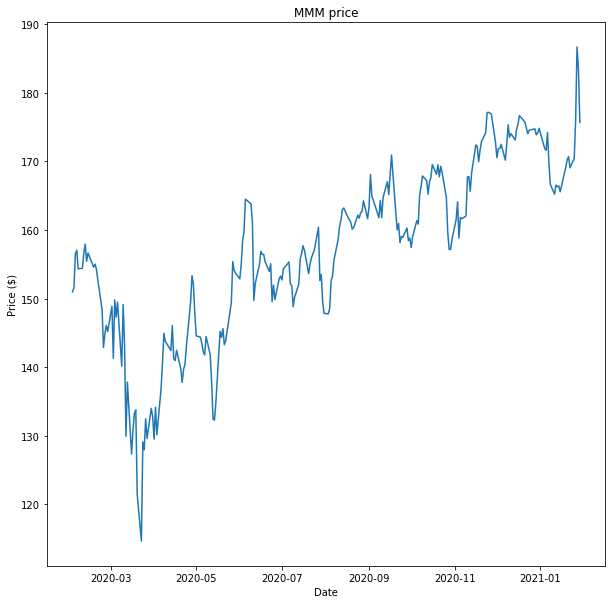

In [126]:
graphPrice(stocks,'MMM')

In [99]:
stocks_idc = stocks
stocks_idc = addBB(stocks_idc,20)        
stocks_idc= addMACD(stocks_idc)
stocks_idc = addRSI(stocks_idc,14)
stocks_idc = addReturns(stocks_idc)
stocks_idc = addVol(stocks_idc,14)
stocks_idc.keys()
features = ['High', 'Low', 'Open', 'Close', 'Volume', 'MA20', '20dSTD', 'UpperBB', 'LowerBB', 'macd', 'macd_signal', 'RSI']
stocks_lagged = lagFeatures(stocks_idc,features,1, ['log_returns', 'simple_returns'])
panel = dict_2_panel(stocks_idc)
port_returns = getPortReturns(stocks_idc)

The columns wanted are ['High', 'Low', 'Open', 'Close', 'Volume', 'MA20', '20dSTD', 'UpperBB', 'LowerBB', 'macd', 'macd_signal', 'RSI', 'log_returns', 'simple_returns']


In [100]:
panel.tail(100)

,High,Low,Open,Close,Volume,Adj Close,MA20,20dSTD,UpperBB,LowerBB,LowerBB_dist,UpperBB_dist,macd,macd_signal,RSI,simple_returns,log_returns,cum_daily_return,volatility,ticker
Date,,,,,,,,,,,,,,,,,,,,
2021-01-20,158.110001,156.429993,157.360001,156.649994,3512500.0,157.740005,155.953001,1.543014,159.039030,152.866972,-3.170461,-3.170461,5.161123,6.187967,72.496263,-0.006112,-0.006131,0.306227,0.025658,ALXN
2021-01-21,157.500000,156.419998,156.500000,156.699997,2106100.0,157.860001,156.002501,1.585230,159.172962,152.832040,-3.223684,-3.223684,4.910163,5.932406,68.821315,0.000761,0.000760,0.307221,0.025186,ALXN
2021-01-22,159.399994,158.100006,159.000000,158.710007,4397000.0,159.729996,156.154001,1.611842,159.377685,152.930317,-3.399806,-3.399806,4.667158,5.679357,69.030460,0.011846,0.011776,0.322706,0.027484,ALXN
2021-01-25,159.100006,157.259995,159.100006,157.740005,3717800.0,161.320007,156.450001,1.699903,159.849807,153.050195,-3.700705,-3.700705,4.572756,5.458037,72.164140,0.009954,0.009905,0.335873,0.028687,ALXN
2021-01-26,158.940002,157.779999,158.240005,157.860001,3579600.0,161.750000,156.854001,1.850353,160.554706,153.153295,-3.756321,-3.756321,4.573522,5.281134,74.524544,0.002665,0.002662,0.339434,0.028653,ALXN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-25,115.070000,113.169998,115.050003,114.190002,718300.0,112.089996,115.875000,2.496700,120.868400,110.881601,-5.089459,-5.089459,0.561211,1.177044,45.867000,-0.013379,-0.013469,0.114815,0.051980,ALLE
2021-01-26,116.000000,113.750000,114.169998,115.040001,928100.0,111.260002,115.841500,2.544729,120.930959,110.752042,-5.350184,-5.350184,0.246419,0.990919,41.739048,-0.007405,-0.007432,0.106560,0.052171,ALLE
2021-01-27,114.459999,112.269997,114.250000,113.610001,582000.0,112.150002,115.753000,2.675092,121.103184,110.402816,-5.565811,-5.565811,-0.069232,0.778889,39.641099,0.007999,0.007967,0.115412,0.046370,ALLE


In [101]:
port_returns.head()

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AFL,A,APD,AKAM,ALK,ALB,ARE,ALXN,ALGN,ALLE
Date,,,,,,,,,,,,,,,,,,,,
2020-10-27,-0.030874,-0.003853,-0.014419,0.007596,0.006523,0.005839,0.007071,-0.040739,-0.005291,-0.011662,-0.038346,0.013476,-0.010126,0.006129,-0.028771,0.007409,-0.004272,-0.006293,0.001276,-0.015668
2020-10-28,-0.015525,-0.019893,-0.026841,-0.025851,-0.030454,-0.024086,-0.045115,-0.031440,-0.026793,-0.041298,-0.034219,-0.041305,-0.037108,-0.087246,-0.046971,-0.046228,-0.025551,-0.042917,-0.034235,-0.029216
2020-10-29,-0.000315,-0.013343,0.002236,-0.100318,0.011686,-0.015694,0.009060,0.021204,-0.002596,0.008937,0.002050,0.003541,0.013884,-0.016222,0.029964,0.032937,-0.004337,0.029256,-0.006689,0.018161
2020-10-30,0.009339,0.001048,0.054915,-0.010722,0.002172,-0.026231,-0.030383,-0.034991,0.008767,-0.001536,-0.007890,0.000686,-0.001915,-0.007305,0.030179,-0.005972,0.000066,-0.025971,-0.024028,0.003975
2020-11-02,0.018630,0.022548,0.037015,0.011791,0.015121,0.008847,-0.004831,-0.007836,0.027838,0.025641,0.046244,0.030855,0.037830,0.007254,0.010029,0.038944,0.022439,-0.002692,0.075948,0.030558


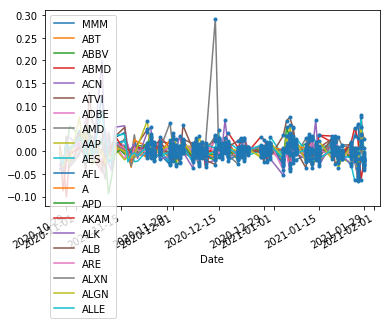

In [102]:
port_returns.plot()
panel['simple_returns'].plot(style='.')

<IPython.core.display.Javascript object>


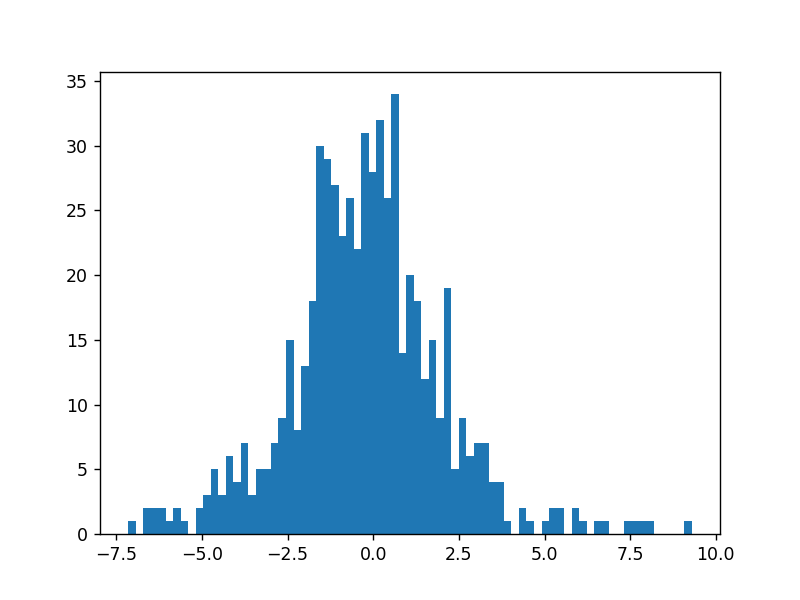

In [78]:
# Convert the decimal returns into percentage returns
percent_return = df['simple_returns']*100

# Drop the missing values
returns_plot = percent_return.dropna()

# Plot the returns histogram
plt.hist(returns_plot, bins=75)
plt.show()

In [106]:
numstocks = len(tickers)
print(numstocks)
weights = getRandomWeights(numstocks)
returns = getPortWeightedReturns(port_returns, weights)

20


In [108]:
list(returns)

[-0.004967870522019894,
 -0.03825438566733644,
 -0.0011013439534726089,
 -3.2946589299451284e-05,
 0.025401970059345896,
 0.011175855373565942,
 0.01902243836628341,
 0.027932297657990084,
 -0.003414156158888867,
 0.01708281532672307,
 -0.0016321287227051657,
 0.0012842110972614957,
 -0.013042383122753244,
 0.01896378880737507,
 0.01288764714215663,
 -0.0010274155106734012,
 -0.012651032709396845,
 0.006437895262608949,
 0.001150830321646916,
 0.014229735740531605,
 0.01109450460382127,
 -0.0013490593901644872,
 0.005231516349616391,
 -4.628199720481236e-05,
 0.007109528128190687,
 -0.00013810680242274184,
 0.0019231140699138623,
 0.014384800181544446,
 -0.008384768478748661,
 0.007119582086633308,
 -0.0073226616567024175,
 -0.00013172364106629606,
 -0.0041205886610082825,
 -0.00014067455873500507,
 0.01580693997662015,
 0.00036027978034947555,
 0.012665535041648638,
 0.0065045422389519115,
 -0.004694107924597708,
 0.005225158817967878,
 0.002946388176689023,
 0.002696976757892583,
 0.

In [111]:
# Calculate the average daily return of the stock
mean_return_daily = np.mean(returns)
print(mean_return_daily)

# Calculate the implied annualized average return
mean_return_annualized = ((1+mean_return_daily)**252)-1
print(mean_return_annualized)

# Calculate the standard deviation of daily return of the stock
sigma_daily = np.std(returns)
print(sigma_daily)

# Calculate the daily variance
variance_daily = sigma_daily**2
print(variance_daily)

# Annualize the standard deviation
sigma_annualized = sigma_daily*np.sqrt(252)
print(sigma_annualized)

# Calculate the annualized variance
variance_annualized = sigma_annualized**2
print(variance_annualized)


# Drop the missing values
clean_returns = returns.dropna()

# Calculate the third moment (skewness) of the returns distribution
returns_skewness = skew(clean_returns)
print(returns_skewness)

# Import kurtosis from scipy.stats
from scipy.stats import kurtosis

# Calculate the excess kurtosis of the returns distribution
excess_kurtosis = kurtosis(clean_returns)
print(excess_kurtosis)

# Derive the true fourth moment of the returns distribution
fourth_moment = excess_kurtosis +3
print(fourth_moment)

# Run the Shapiro-Wilk test on the stock returns
shapiro_results = shapiro(clean_returns)
print("Shapiro results:", shapiro_results)

# Extract the p-value from the shapiro_results
p_value = shapiro_results
print("P-value: ", p_value)

# if p value is less than 0.05, null is rejected, so the data is non-normal

0.0025377106439864417
0.8940038274340041
0.011389059903967652
0.00012971068549616366
0.18079572103629346
0.032687092745033244
-0.7155157470229345
1.9916089575657407
4.991608957565741
Shapiro results: ShapiroResult(statistic=0.9555303454399109, pvalue=0.020153269171714783)
P-value:  ShapiroResult(statistic=0.9555303454399109, pvalue=0.020153269171714783)
